## Imports e úteis

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import tensorflow_probability as tfp
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import numpy as np
from scipy.io import loadmat
from scipy.optimize import fmin_l_bfgs_b
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from keras.models import Model
from keras.layers import Input, Dense, Layer
from keras.losses import Loss, mse
from keras.initializers import GlorotNormal
from keras.optimizers import Optimizer

np.random.seed(1234)
tf.random.set_seed(1234)

In [2]:
def printest(args, valor):
    return print( "{} : \n {} \n".format(args, valor) )


# PINN : Navier Strokes

## Otimizador

In [10]:
class L_BFGS_B:
    def __init__(self, model, x_train, y_train, factr = 1e4, m=50, maxls=50, maxiter=1000):
        self.model = model
        #x_train = xyt, y_train = uv
        self.x_train =  x_train #tf.constant(x_train, dtype=tf.float32)
        self.y_train = y_train  #tf.constant(y_train, dtype=tf.float32) 
        # quando iteração termina 
        self.factr = factr
        #The maximum number of variable metric corrections used 
        self.m = m
        #max number of line search steps/iteration
        # nesse caso 50/iteração
        self.maxls = maxls 
        #max number of interation
        self.maxiter = maxiter

    # 1D --> ND
    def set_weights(self, weights_1d):

        weights_shapes = [ w.shape for w in self.model.get_weights() ]

        n = [0] + [ np.prod(shape) for shape in weights_shapes ] 
        partition = np.cumsum(n) 

        weights = [ weights_1d[from_part:to_part].reshape(shape)
                    for from_part, to_part, shape 
                    in zip(partition[:-1], partition[1:], weights_shapes) ]

        self.model.set_weights(weights)
        
    @tf.function
    def tf_evaluate(self, x, y):
        # x = xyt , y = uv
        with tf.GradientTape() as g:
            uv_fuv = self.model([x, y])       
            loss = self.model.losses[0]
        grads = g.gradient(loss, self.model.trainable_variables, unconnected_gradients=tf.UnconnectedGradients.ZERO)
        printest('grads',[g for g in grads])
        return loss, grads

    def evaluate(self, weights_1d):

        self.set_weights(weights_1d)
        loss, grads = self.tf_evaluate(self.x_train, self.y_train)
        #printest('loss', loss)
        loss = loss.numpy().astype('float64')
        #printest('loss', loss)
        grads = np.concatenate([ g.numpy().flatten() for g in grads ]).astype('float64')
        #printest('grads',grads)
        
        return loss, grads
    
    def fit(self):

        initial_weights = np.concatenate(
            [ w.flatten() for w in self.model.get_weights() ])
            
        #self.evaluate(initial_weights)
        fmin_l_bfgs_b(func = self.evaluate, x0 = initial_weights,
                        factr = self.factr, m = self.m,   
                        maxls = self.maxls, maxiter = self.maxiter) 


## Layer: automatic Differentiation and Loss

In [4]:
# funcionando normalmente!
# tempo 4.5 s, mais rapido que ot este
class AutomaticDiff(Layer):

    def __init__(self, model):
        
        self.model = model
        super().__init__()
        self.lambda_1 = tf.Variable([0.0], trainable=True, dtype=tf.float32)
        self.lambda_2 = tf.Variable([0.0], trainable=True, dtype=tf.float32)
    
    def call(self, input): 
        with tf.GradientTape(persistent = True) as ggg:
            ggg.watch(input)
            with tf.GradientTape(persistent = True) as gg:
                gg.watch(input)
                with tf.GradientTape(persistent = True) as g:
                    g.watch(input)

                    x = input[:,0:1]        # (5000, 1)
                    y = input[:,1:2]        # (5000, 1)
                    t = input[:,2:3]        # (5000, 1)
                    xy = tf.concat([x, y], axis = 1)        # (5000, 2)
                    xyt = tf.concat([xy, t], axis = 1)      # (5000, 3)
                    
                    p_psi = self.model(xyt) # (5000, 2)              
                    p   = p_psi[:,0:1]      # (5000, 1)
                    psi = p_psi[:,1:2]      # (5000, 1)    

                dpdpsi_dxdy = g.batch_jacobian(p_psi, xy)  ## (5000, 2, 2)
                dp_dxdy   = dpdpsi_dxdy[:,0,:] # (5000, 2 )
                dp_dx = dp_dxdy[:,0:1]      # (5000, 1 )
                dp_dy = dp_dxdy[:,1:2]      # (5000, 1 )
                # --> dpsi_dx = -v and dpsi_dy = u
                dpsi_dxdy = dpdpsi_dxdy[:,1,:] # (5000, 2 )
                v = (-1)*dpsi_dxdy[:, 0:1]  # (5000, 1 )
                u = dpsi_dxdy[:, 1:2]       # (5000, 1 )         
            #printest('v', v)    
            #printest('u', u)  
            dpsi_dxdy_dxdydt = gg.batch_jacobian(dpsi_dxdy, xyt) # (5000, 2, 3)
            #printest('dpsi_dxdy_dxdydt',dpsi_dxdy_dxdydt)
            # from continuity eq u_x + u_y = 0 
            # --> dpsi_dx = -v and dpsi_dy = u
            # --> (dpsi_dy)dx_dxdydt = du_dxdydt
            du_dxdydt = dpsi_dxdy_dxdydt[:,1,:]            ## (5000, 3)
            du_dx = du_dxdydt[:,0:1]       # (5000, 1)
            du_dy = du_dxdydt[:,1:2]       # (5000, 1)
            du_dt = du_dxdydt[:,2:3]       # (5000, 1)
            # --> (dpsi_dx)dy_dxdydt = (-1)*dv_dxdydt
            dv_dxdydt = (-1)*dpsi_dxdy_dxdydt[:,0,:]       ## (5000, 3)
            dv_dx = dv_dxdydt[:,0:1]       # (5000, 1)
            dv_dy = dv_dxdydt[:,1:2]       # (5000, 1)
            dv_dt = dv_dxdydt[:,2:3]       # (5000, 1)
        #-------------------------------------------------------------------
        d2u_dx2 = ggg.gradient(du_dx, x)   #(5000, 1)
        d2u_dy2 = ggg.gradient(du_dx, y)   #(5000, 1)
        d2v_dx2 = ggg.gradient(dv_dx, x)   #(5000, 1)
        d2v_dy2 = ggg.gradient(dv_dx, y)   #(5000, 1)
        #-------------------------------------------------------------------
        #printest('d2u_dx2', d2u_dx2)
        #printest('d2u_dy2', d2u_dy2)
        #printest('d2v_dx2', d2v_dx2)
        #printest('d2v_dy2', d2v_dy2)
        del g, gg, ggg

        f_u = du_dt + self.lambda_1*(u*du_dx + v*du_dy) + dp_dx - self.lambda_2*(d2u_dx2 + d2u_dy2) 
        #printest('f_u', f_u)
        
        f_v = dv_dt + self.lambda_1*(u*dv_dx + v*dv_dy) + dp_dy - self.lambda_2*(dv_dx + d2v_dy2)
        #printest('f_v', f_v)
        
        output = tf.concat([u, v, f_u, f_v], axis = 1)
        return output


In [5]:
class AddLoss(Layer):
    def __init__(self):
        super().__init__()

    def call(self, y_true, y_pred):
        self.add_loss(self.custom_mse(y_true, y_pred))
        return y_pred
    
    def custom_mse(self, y_true, y_pred ):
        
        u_true, u_pred = y_true[:,0:1], y_pred[:,0:1]
        loss_1 =  tf.reduce_sum(tf.square(u_true - u_pred))
        
        v_true, v_pred = y_true[:,1:2], y_pred[:,1:2]
        loss_2 =  tf.reduce_sum(tf.square(y_true[:,1:2] - y_pred[:,1:2]))
        
        f_u_pred, f_v_pred = y_pred[:,2:3], y_pred[:,3:4]
        loss_3 =  tf.reduce_sum(tf.square(f_u_pred)) + tf.reduce_sum(tf.square(f_v_pred))
        
        loss = loss_1 + loss_2 + loss_3
        return loss

## Model: Neural Network

In [6]:
class NeuralNet(Model):
#[100, 100, 100, 100, 100, 100, 100, 100]
    def __init__(self, hidden_units = [ 20, 20], input_unit = 3, output_unit = 2, activation_func = 'tanh', initializer = "glorot_normal"):
        super().__init__()

        self.units = hidden_units
        self.input_unit = input_unit
        self.output_unit = output_unit
        self.activation_func = activation_func
        self.initializer = initializer
        # Hidden Layer
        self.hidden_layer = []
        count = 0
        for unit in hidden_units:
            self.hidden_layer.append( Dense( units = unit, 
                                             kernel_initializer = self.initializer, 
                                             activation = activation_func,
                                             name = 'Hidden_{}'.format(count) ) )
            count += 1
            
        # Output layer    
        self.output_layer = Dense( units = output_unit, 
                                    kernel_initializer = self.initializer,
                                    name = "Output" )

    def call(self, x): # call directly if dont need intermediate step
        for hidden in self.hidden_layer:
            x = hidden(x)
        x = self.output_layer(x)
        return x

    def build(self): # intermediate step to generate a graph
        x = Input( shape = (self.input_unit,), name = "Input" )
        return Model( inputs = [x], 
                        outputs = self.call(x), 
                        name = "NeuralNetwork" )

### Model: graph visualization

In [241]:
nn_model = NeuralNet().build()

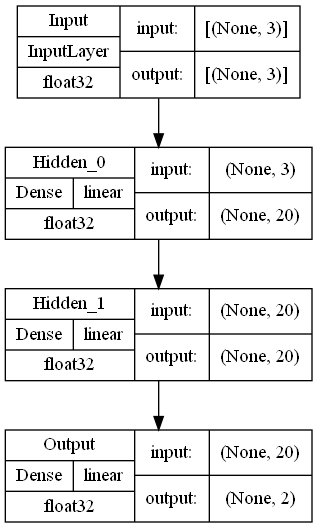

In [242]:

tf.keras.utils.plot_model(nn_model, to_file= './model_1.png', show_shapes=True, 
                    show_dtype=True, show_layer_names=True, show_layer_activations = True)

## Model: Physics Informed

In [7]:
class PhysicsInformedNN(Model):
    def __init__(self, model):
        super(PhysicsInformedNN, self).__init__()
        
        # init layers 
        self.model = model
        self.grad_layer = AutomaticDiff(model)
        self.addloss_layer = AddLoss( )
    
    def call(self, inputs):
        xyt = inputs[0]
        uv = inputs[1]
        # uv_fuv =  u, v, f_u, f_v
        uv_fuv =  self.grad_layer(xyt) 
        uv_fuv = self.addloss_layer(y_true = uv, y_pred = uv_fuv)
        return uv_fuv
    
    def build(self):
        # problkema esta em xyt ser um placeholder     
        xyt = Input(shape = (3,), name = "InputLayer_xyt")
        uv = Input(shape = (2,), name = "InputLayer_uv")
        inputs = [xyt, uv]
        return Model(inputs = inputs,
                     outputs = self.call(inputs),
                     name = 'PhysicsInformedNN')

### Model: graph visualization

In [373]:
pinn_model = PhysicsInformedNN(model = nn_model).build()

d2u_dx2 : 
 Tensor("gradient_tape/automatic_diff_91/Slice_10:0", shape=(None, 1), dtype=float32) 

d2u_dy2 : 
 Tensor("gradient_tape/automatic_diff_91/Slice_15:0", shape=(None, 1), dtype=float32) 

d2v_dx2 : 
 Tensor("gradient_tape/automatic_diff_91/Slice_18:0", shape=(None, 1), dtype=float32) 

d2v_dy2 : 
 Tensor("gradient_tape/automatic_diff_91/Slice_23:0", shape=(None, 1), dtype=float32) 

f_u : 
 Tensor("automatic_diff_91/sub:0", shape=(None, 1), dtype=float32) 

f_v : 
 Tensor("automatic_diff_91/sub_1:0", shape=(None, 1), dtype=float32) 



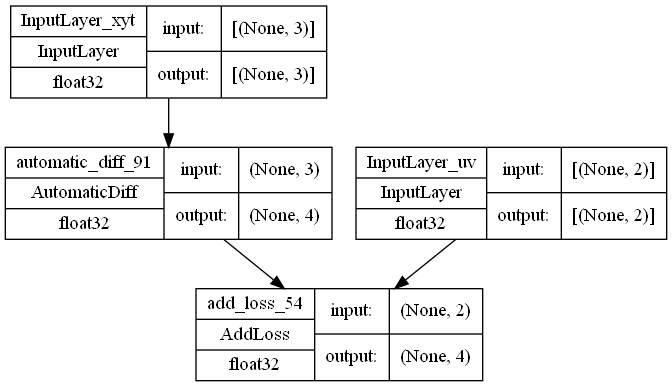

In [374]:
tf.keras.utils.plot_model(pinn_model, to_file= './pinn_1.png', show_shapes= True,
                    show_dtype=True, show_layer_names=True, show_layer_activations = True)

## Main

In [8]:
n_train = 500

# load dictionary Data
# keys: 'X_star: [x, y]', 'U_star : [u, v]', 'p_star : [p]', 't : [t]',
data = loadmat('./Data/cylinder_nektar_wake.mat')

# Rearrange Data                        shapes:
uv = data['U_star']                 # (5000, 2, 200) - N x 2 X T
u = uv[:,0,:]                       # (5000, 200)     - N x T
v = uv[:,1,:]                       # (5000, 200)     - N x T

# N = 5000, T = 200
N,T = (uv.shape[0], uv.shape[2]) 

xy = data['X_star']                 # (5000, 2)     - N x 2
x = np.tile(xy[:, 0:1], (1,T))      # (5000, 200)    - N x T
y = np.tile(xy[:, 1:2], (1,T))      # (5000, 200)    - N x T

t = data['t']                       # (200 , 1)      - T x 1
t = np.tile(t, (1,N)).T             # (5000, 200)     - N x T
p = data['p_star']                  # (5000, 200)     - N x T

# 1D arrays : (10000, 1) - NT x 1
x_1d = x.flatten()[:,None]
y_1d = y.flatten()[:,None]
t_1d = t.flatten()[:,None]

u_1d = u.flatten()[:,None]          
v_1d = v.flatten()[:,None]          
p_1d = p.flatten()[:,None]

# Training Data : (5000, 1)
indices = np.random.choice(N*T, n_train, replace = False)
x_train = x_1d[indices]
y_train = y_1d[indices]
t_train = t_1d[indices]
u_train = u_1d[indices]
v_train = v_1d[indices]

xyt = tf.concat( (x_1d[indices], y_1d[indices], t_1d[indices]), axis = 1)
uv  = tf.concat( (u_1d[indices], v_1d[indices]), axis = 1) 


In [11]:
nn_model = NeuralNet().build()
pinn_model = PhysicsInformedNN(model = nn_model).build()

In [12]:
lbfgs = L_BFGS_B(model = pinn_model, x_train = xyt, y_train = uv)
lbfgs.fit()

grads : 
 [<tf.Tensor 'AddN_42:0' shape=(1,) dtype=float32>, <tf.Tensor 'AddN_43:0' shape=(1,) dtype=float32>, <tf.Tensor 'AddN_41:0' shape=(3, 20) dtype=float32>, <tf.Tensor 'gradient_tape/PhysicsInformedNN/automatic_diff_1/NeuralNetwork/Hidden_0/BiasAdd/BiasAddGrad_6:0' shape=(20,) dtype=float32>, <tf.Tensor 'AddN_39:0' shape=(20, 20) dtype=float32>, <tf.Tensor 'gradient_tape/PhysicsInformedNN/automatic_diff_1/NeuralNetwork/Hidden_1/BiasAdd/BiasAddGrad_6:0' shape=(20,) dtype=float32>, <tf.Tensor 'gradient_tape/gradient_tape/PhysicsInformedNN/automatic_diff_1/NeuralNetwork/Output/MatMul/MatMul/pfor/MatMul/MatMul_5:0' shape=(20, 2) dtype=float32>, <tf.Tensor 'zeros_like:0' shape=(2,) dtype=float32>] 

